# Calculating time scales for *cis/trans* isomerization


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle

## Load in Important Function

In [2]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

In [3]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    
    shifted_omega = (omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    return cistrans

### Load in the omega angle trajectories by replica

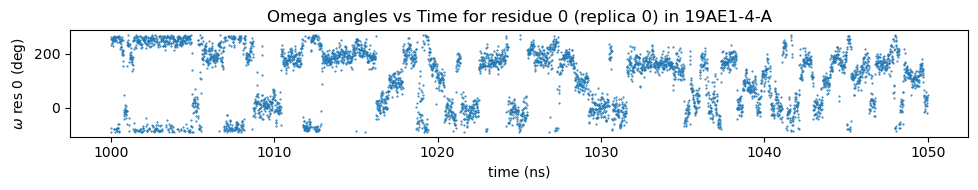

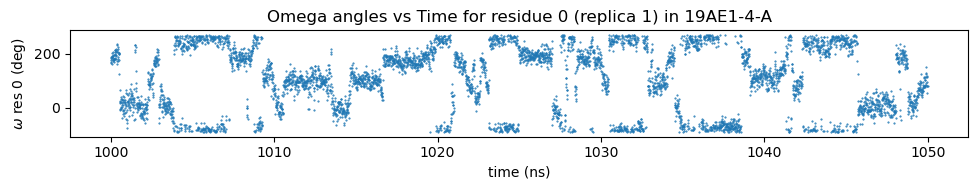

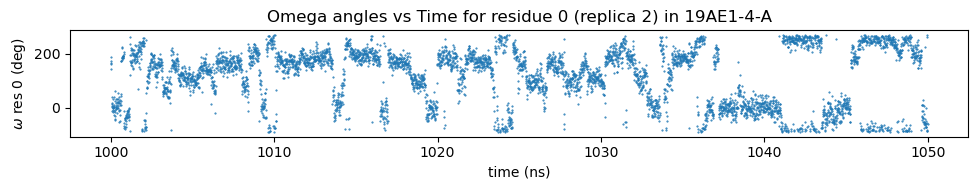

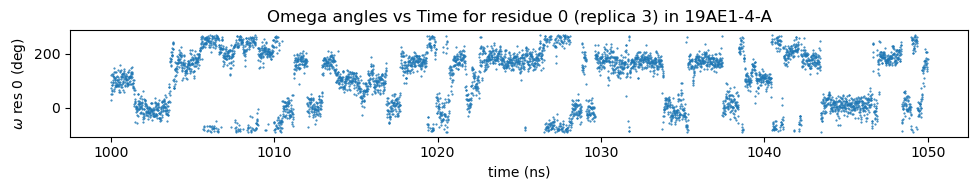

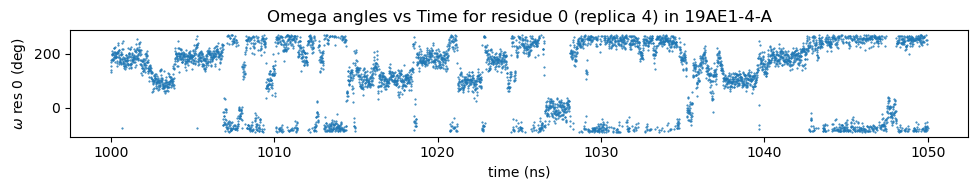

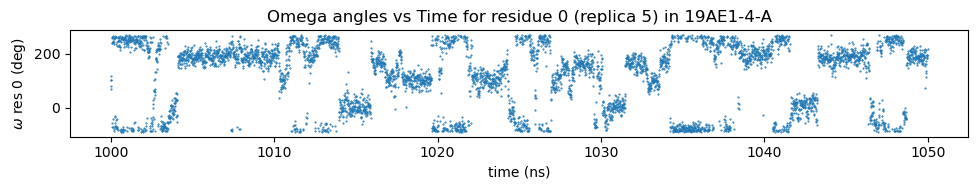

In [17]:
# Load in the omega angles by replica
dt_in_ns = 0.010   # 10 ps per snapshot
nreplicas = 6

omegas_by_replica = []
for i in range(nreplicas):
    # load in the angles
    angles = np.array(Data.load(f'omega_data/omegas_rep{i}.pkl').array_list)
    # shift into (-90, 270) range to avoid periodic boundaries
    omegas_by_replica.append( (angles + 90.0)%360.0 - 90.0)
# print(omegas_by_replica)

# Plot omega angles vs time for selected residues for each replica
residues_to_plot = [0]
start = 100000
nsnaps = 105000
for i in range(nreplicas):
    plt.figure(figsize=(10, 2))
    for panel, residue in enumerate(residues_to_plot, 1):
        plt.subplot(len(residues_to_plot), 1, panel)
        t = np.arange(start, nsnaps) * 0.010  # Time axis in ns
        plt.plot(t, omegas_by_replica[i][start:nsnaps, residue], '.', ms=1)
        plt.xlabel('time (ns)')
        plt.ylabel(f'$\\omega$ res {residue} (deg)')
        plt.title(f'Omega angles vs Time for residue {residue} (replica {i}) in 19AE1-4-A')
    plt.tight_layout()
plt.show()



## Convert the omega angle trajectories to cis(0)/trans(1) trajectories 

In [6]:
cistrans_by_replica = []
for i in range(nreplicas):
    cistrans_by_replica.append( (np.where(omegas_by_replica[i] > 90.0, 1, 0)).astype(int) )

print(cistrans_by_replica)
print(f"The Shape of cistrans_by_replica is : {np.shape(cistrans_by_replica)}")


[array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       ...,
       [1, 0, 1],
       [1, 0, 1],
       [1, 1, 1]]), array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       ...,
       [1, 0, 1],
       [1, 0, 1],
       [1, 1, 1]]), array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       ...,
       [1, 0, 1],
       [1, 0, 1],
       [1, 1, 1]]), array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       ...,
       [1, 0, 1],
       [1, 0, 1],
       [1, 1, 1]]), array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       ...,
       [1, 0, 1],
       [1, 0, 1],
       [1, 1, 1]]), array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       ...,
       [1, 0, 1],
       [1, 0, 1],
       [1, 1, 1]])]
The Shape of cistrans_by_replica is : (6, 600030, 3)


#### compile transition probabilities as a function of lag time (in steps)

In [5]:
def get_transition_matrix(cistrans_traj, lagtime=10, sliding_window=True, pseudocount=0.25):
    """Returns a row-normalized transiton matrix T for a given lagtime (in steps)."""

    C = np.zeros( (2,2) )   # count matrix
    T = np.zeros( (2,2) )   # transition matrix
    
    N = len(cistrans_traj)  # the length of the trajectory
    for t in range(0, N-lagtime):
        C[cistrans_traj[t],cistrans_traj[t+lagtime]] += 1.0

    # add pseudocounts to avoid zero entries
    C += pseudocount    
    
    # row-normalize
    T[0,:] = C[0,:]/C[0,:].sum()
    T[1,:] = C[1,:]/C[1,:].sum()

    return T

def implied_timesale(T, lagtime=1):
    """Return the implied timescale, in units of number of steps.
    
    INPUT
    T       - transition matrix where T_ij is prob of transitioning i -> j in lagtime.
    
    PARAMETERS
    lagtime - lagtime used to build T (in units of steps). Default = 1
    
    RETURN
    t2      - the implied timescale (in units of steps)
    """
    try:
        evals = np.linalg.eigvals( T.transpose() )  # will be something like [0.99754545 1.        ]
        mu2 = min(evals) # non-stational eigenvalue of T
        # print('mu2', mu2, 'evals', evals, 'T', T)
        t2 = -1.0*lagtime/np.log(mu2)  # the implied timescale relation
    except:
        t2 = np.nan
        
    return t2
    
    

## Let's make an implied timescale plot for each omega angle

lagtimes = [1, 10, 25, 50, 100, 10100, 20100, 30100, 40100, 50100, 60100, 70100, 80100, 90100, 100100, 110100, 120100, 130100, 140100, 150100, 160100, 170100, 180100, 190100, 200100, 210100, 220100, 230100, 240100, 250100, 260100, 270100, 280100, 290100, 300100, 310100, 320100, 330100, 340100, 350100, 360100, 370100, 380100, 390100, 400100, 410100, 420100, 430100, 440100, 450100, 460100, 470100, 480100, 490100, 500100, 510100, 520100, 530100, 540100, 550100, 560100, 570100, 580100, 590100]


/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_26851/3580757966.py:36: RuntimeWarning: invalid value encountered in log
  t2 = -1.0*lagtime/np.log(mu2)  # the implied timescale relation


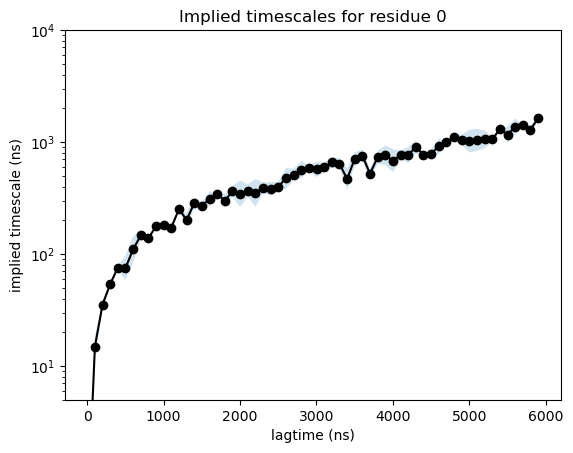

lagtimes = [1, 10, 25, 50, 100, 10100, 20100, 30100, 40100, 50100, 60100, 70100, 80100, 90100, 100100, 110100, 120100, 130100, 140100, 150100, 160100, 170100, 180100, 190100, 200100, 210100, 220100, 230100, 240100, 250100, 260100, 270100, 280100, 290100, 300100, 310100, 320100, 330100, 340100, 350100, 360100, 370100, 380100, 390100, 400100, 410100, 420100, 430100, 440100, 450100, 460100, 470100, 480100, 490100, 500100, 510100, 520100, 530100, 540100, 550100, 560100, 570100, 580100, 590100]


/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_26851/3580757966.py:36: RuntimeWarning: invalid value encountered in log
  t2 = -1.0*lagtime/np.log(mu2)  # the implied timescale relation
/Users/starwingchen/anaconda3/envs/PeptoidFF/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/starwingchen/anaconda3/envs/PeptoidFF/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/starwingchen/anaconda3/envs/PeptoidFF/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/starwingchen/anaconda3/envs/PeptoidFF/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arr

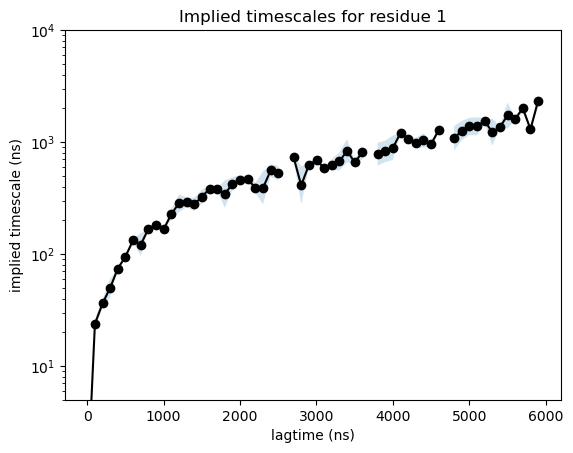

lagtimes = [1, 10, 25, 50, 100, 10100, 20100, 30100, 40100, 50100, 60100, 70100, 80100, 90100, 100100, 110100, 120100, 130100, 140100, 150100, 160100, 170100, 180100, 190100, 200100, 210100, 220100, 230100, 240100, 250100, 260100, 270100, 280100, 290100, 300100, 310100, 320100, 330100, 340100, 350100, 360100, 370100, 380100, 390100, 400100, 410100, 420100, 430100, 440100, 450100, 460100, 470100, 480100, 490100, 500100, 510100, 520100, 530100, 540100, 550100, 560100, 570100, 580100, 590100]


/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_26851/3580757966.py:36: RuntimeWarning: invalid value encountered in log
  t2 = -1.0*lagtime/np.log(mu2)  # the implied timescale relation
/Users/starwingchen/anaconda3/envs/PeptoidFF/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/starwingchen/anaconda3/envs/PeptoidFF/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/starwingchen/anaconda3/envs/PeptoidFF/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/starwingchen/anaconda3/envs/PeptoidFF/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arr

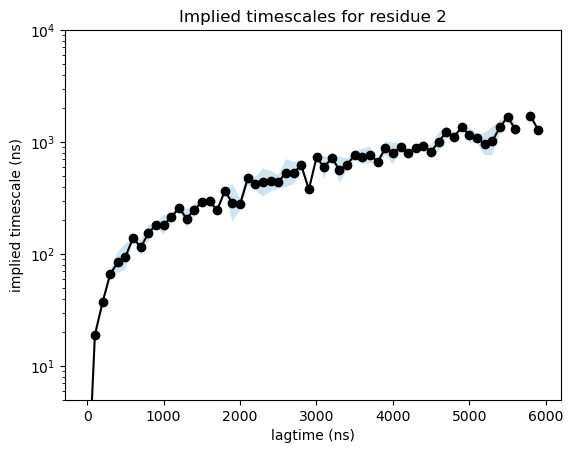

In [6]:
residues = [0,1,2]
for residue in residues:
    
    lagtimes = [1, 10, 25, 50] + list(range(100, 600030, 10000))
    print('lagtimes =', lagtimes)
    
    t2_means = []  # mean timescales for each lagtime
    t2_uppers  = []  # upperlim of standard deviation of log t2 for each lagtime
    t2_lowers  = []  # lowerlim
    
    for lagtime in lagtimes:
    
        # Each replica is a separate data set we can use for uncertainty estimation
        logt2_values = []    
        for i in range(nreplicas):
            T = get_transition_matrix(cistrans_by_replica[i][:,residue], lagtime=lagtime)
            logt2_values.append(np.log(implied_timesale(T, lagtime=lagtime)))
        logt2_values = np.array(logt2_values)    
        Ind = ~np.isnan(logt2_values)
        t2_means.append( np.exp(np.mean(logt2_values[Ind] ) ))
        t2_uppers.append( np.exp( np.mean(logt2_values[Ind] ) + np.std(logt2_values[Ind]) ))
        t2_lowers.append( np.exp( np.mean(logt2_values[Ind] ) - np.std(logt2_values[Ind]) ))
    
    t2_means = np.array(t2_means)
    t2_uppers = np.array(t2_uppers)
    t2_lowers = np.array(t2_lowers)
    lagtimes  = np.array(lagtimes)
    
    plt.figure()
    plt.plot(lagtimes*dt_in_ns, t2_means*dt_in_ns, 'ko-')
    plt.fill_between(lagtimes*dt_in_ns, t2_uppers*dt_in_ns, t2_lowers*dt_in_ns, alpha=0.2)
    plt.xlabel('lagtime (ns)')
    plt.ylabel('implied timescale (ns)')
    plt.ylim(5,10000)
    plt.yscale('log')
    plt.title(f'Implied timescales for residue {residue}')
    plt.show()
    